In [1]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/lena.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.


In [3]:
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import RevDuffing,VanDerPol
from learn_KKL.learner import Learner
from learn_KKL.raffinement import *
#sb.set_style('whitegrid')

In [4]:
import matplotlib.pyplot as plt

In [15]:
# Set up the system
system = RevDuffing()

In [123]:
# Instantiate the observer
observer = LuenbergerObserver(dim_x=2, dim_y=1, method='Supervised', recon_lambda=0.8, wc=0.03,
                              activation=torch.nn.SiLU())
observer.set_dynamics(system)
# Generate (x_i, z_i) data by running system backward, then system + observer
# forward in time
data,grid = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [20,20],
                                  method='adaptative')

In [70]:
data, val_data = train_test_split(data, test_size=0.3, shuffle=True)

torch.Size([400, 5])


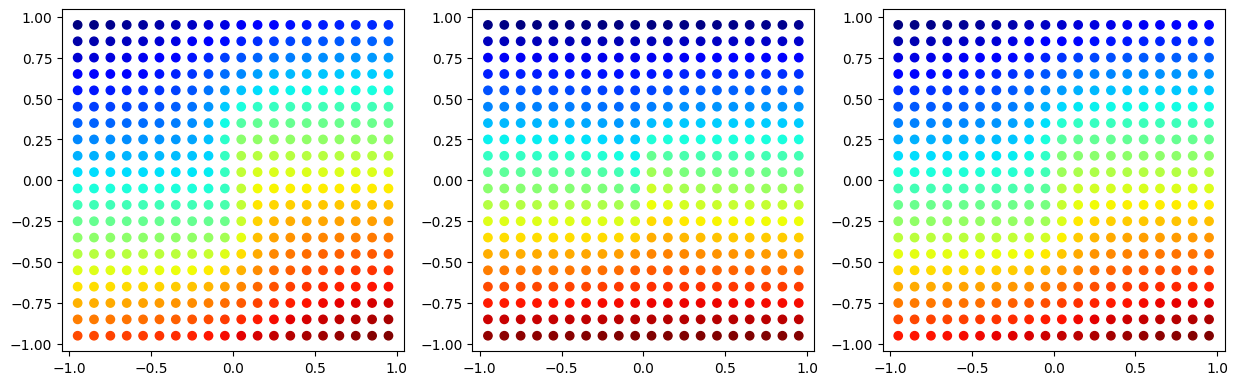

In [124]:
print(data.shape)
im,ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    ax[i].scatter(data[:,0],data[:,1],c = data[:,2+i],cmap='jet')
    ax[i].axis('square')
plt.show()

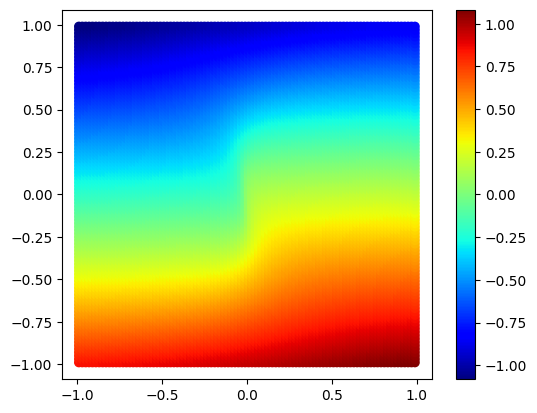

In [105]:
plt.scatter(data[:,0],data[:,1],c = data[:,2+2],cmap='jet')
plt.axis('square')
plt.colorbar()
plt.show()

In [125]:
nx,ny = 4,4
Coeff1 = coeffs(grid,data[:,2],nx,ny)
print('coeff1')
Coeff2 = coeffs(grid,data[:,3],nx,ny)
print('coeff2')
Coeff3 = coeffs(grid,data[:,4],nx,ny)
print('coeff3')

coeff1
coeff2
coeff3


In [126]:
g1,g2,g3 = [],[],[]
for cell in grid:
    g1.append(np.array(gradient(cell,nx,ny,Coeff1)))
    g2.append(np.array(gradient(cell,nx,ny,Coeff2)))
    g3.append(np.array(gradient(cell,nx,ny,Coeff3)))
g1,g2,g3 = np.array(g1),np.array(g2),np.array(g3)

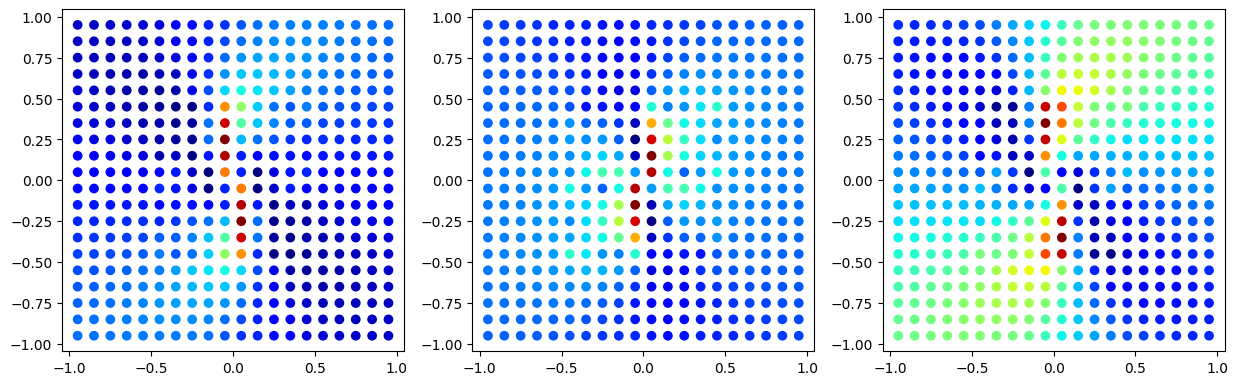

In [127]:
_,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
ax1.scatter(data[:,0],data[:,1],c = np.sqrt(g1[:,0]**2+g1[:,1]**2),cmap='jet')
ax1.axis('square')
ax2.scatter(data[:,0],data[:,1],c = np.sqrt(g2[:,0]**2+g2[:,1]**2),cmap='jet')
ax2.axis('square')
ax3.scatter(data[:,0],data[:,1],c = np.sqrt(g3[:,0]**2+g3[:,1]**2),cmap='jet')
ax3.axis('square')
plt.show()

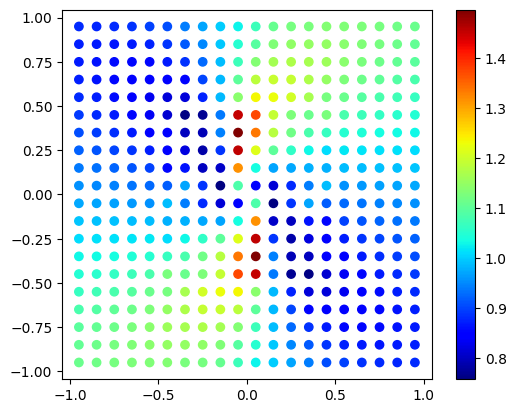

In [128]:
plt.scatter(data[:,0],data[:,1],c = np.sqrt(g3[:,0]**2+g3[:,1]**2),cmap='jet')
plt.axis('square')
plt.colorbar()
plt.show()

In [129]:
import time
start = time.time()
data1, grid1, data2, grid2, data3, grid3 = observer.iterate(data,grid,data,grid,data,grid)
end = time.time()
print("temps d'execution :",int((end-start)/60),"min et",end-start-60*int((end-start)/60),"s")

temps d'execution : 9 min et 41.37120842933655 s


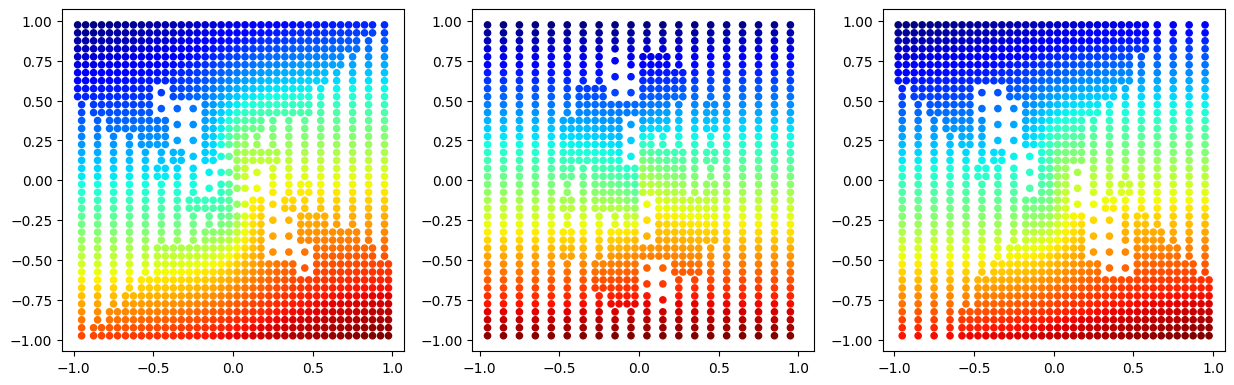

In [130]:
_,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
ax1.scatter(data1[:,0],data1[:,1],c=data1[:,2],s=20,cmap='jet')
ax1.axis('square')
ax2.scatter(data2[:,0],data2[:,1],c=data2[:,3],s=20,cmap='jet')
ax2.axis('square')
ax3.scatter(data3[:,0],data3[:,1],c=data3[:,4],s=20,cmap='jet')
ax3.axis('square')
plt.show()

In [131]:
start = time.time()
data1, grid1, data2, grid2, data3, grid3 = observer.iterate(data1,grid1,data2,grid2,data3,grid3)
end = time.time()
print("temps d'execution :",int((end-start)/60),"min et",end-start-60*int((end-start)/60),"s")

temps d'execution : 14 min et 44.99869704246521 s


torch.Size([4190, 5])
torch.Size([2552, 5])
torch.Size([3930, 5])


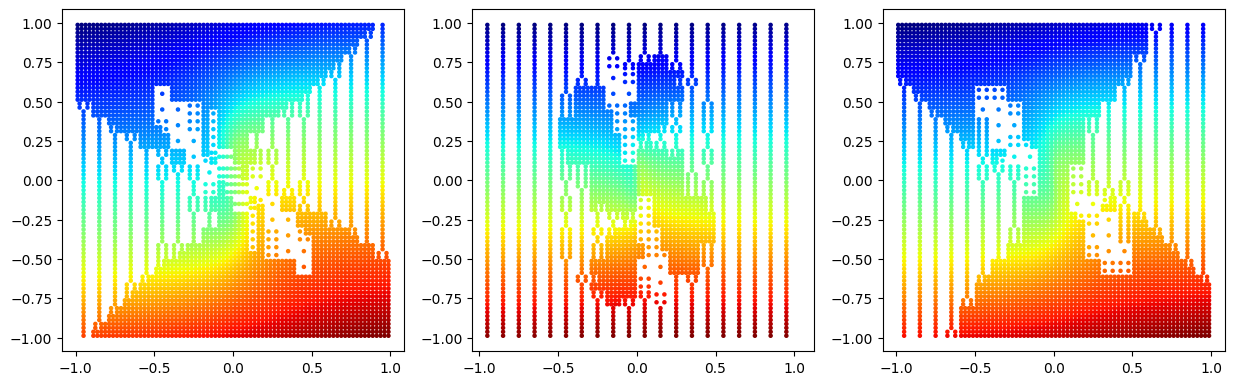

In [139]:
print(data1.shape)
print(data2.shape)
print(data3.shape)
_,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
ax1.scatter(data1[:,0],data1[:,1],c=data1[:,2],s=5,cmap='jet')
ax1.axis('square')
ax2.scatter(data2[:,0],data2[:,1],c=data2[:,3],s=5,cmap='jet')
ax2.axis('square')
ax3.scatter(data3[:,0],data3[:,1],c=data3[:,4],s=5,cmap='jet')
ax3.axis('square')
plt.show()

In [156]:
data2, val_data = train_test_split(data2, test_size=0.3, shuffle=True)

In [157]:
# Train the forward transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=data2,
                    validation_data=val_data, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T\exp_9


In [158]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T)
# learner_T.save_results(limits=np.array([[-1, 1.], [-1., 1.], [-1., 1.]]),
#                        nb_trajs=10, tsim=(0, 60), dt=1e-2,
#                        checkpoint_path=checkpoint_callback.best_model_path)

Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T\exp_9/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Logs stored in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T\exp_9/tb_logs


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [159]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data2,
                         validation_data=val_data, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_7


In [160]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T_star.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T_star)
# learner_T_star.save_results(limits=np.array([[-1, 1.], [-1., 1.]]),
#                             nb_trajs=10, tsim=(0, 60), dt=1e-2,
#                             checkpoint_path=checkpoint_callback.best_model_path)

Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_7/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Logs stored in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_7/tb_logs


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

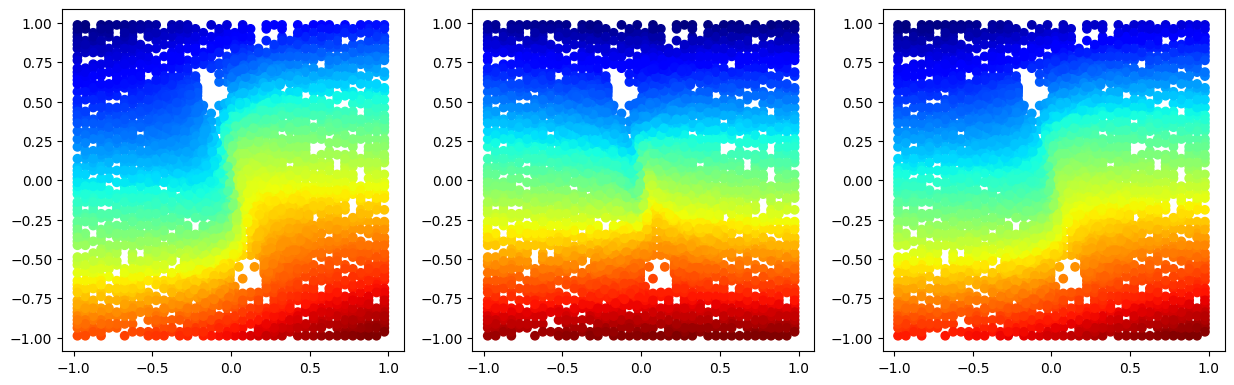

In [165]:
x_mesh = data2[:, 0:2]
z_mesh = data2[:, 2:5]
z_hat = learner_T.model("T", x_mesh)
x_hat = learner_T_star.model("T_star",z_mesh)
erreur_z = torch.abs(z_hat - z_mesh)
erreur_x = torch.abs(x_hat - x_mesh)
im,ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    ax[i].scatter(x_mesh[:,0],x_mesh[:,1],c = z_hat[:,i],cmap='jet')
    ax[i].axis('square')
plt.show()

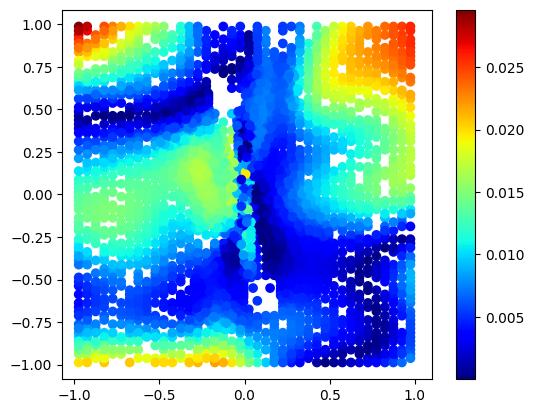

In [164]:
plt.scatter(x_mesh[:,0],x_mesh[:,1],c = erreur_z[:,2],cmap='jet')
plt.axis('square')
plt.colorbar()
plt.show()

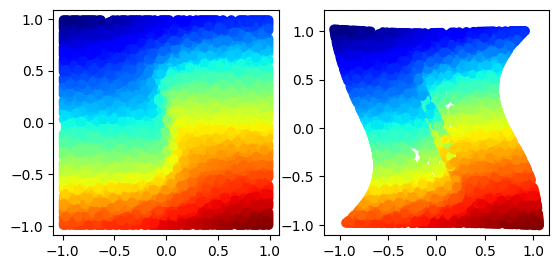

In [83]:
im,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(x_mesh[:,0],x_mesh[:,1],c=z_hat[:,0],cmap='jet')
ax1.axis('square')
ax2.scatter(x_hat[:,0].detach(),x_hat[:,1].detach(),c=z_hat[:,0],cmap='jet')
ax2.axis('square')
plt.show()